Distributions and Models

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import os


# Define the log joint probability function
def log_joint(x, theta, z, alpha = 1):
    # Shift z to compute differences (prepend 0)

    zero_tensor = torch.zeros((z.size(0), 1), device=z.device)
    # Concatenate the zero tensor with z[:-1] along the first dimension
    z_shifted = torch.cat([zero_tensor, z[:, :-1]], dim=1)

    # Compute the log joint probability
    log_prob_x = -0.5 / sigma ** 2 * torch.sum((x - theta - torch.sin(z)) ** 2, dim=1)
    log_prob_z = -0.5 / tau ** 2 * torch.sum((z - 0.8*z_shifted) ** 2, dim=1)

    return alpha * log_prob_x + log_prob_z


# Define the log variational distribution (q)
def log_q(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    # Compute log_q for theta
    log_q_theta = torch.sum(
        -0.5 * torch.log(2 * torch.pi * nu_sd_theta ** 2) - 0.5 * ((theta - nu_mean_theta) ** 2) / (nu_sd_theta ** 2),
        dim=1
    )
    log_q_z = torch.sum(
        -0.5 * torch.log(2 * torch.pi * nu_sd_z ** 2) - 0.5 * ((z - nu_mean_z) ** 2) / (nu_sd_z ** 2),
        dim=1
    )

    return log_q_theta + log_q_z

def log_q_s(theta, z,
            nu_mean_theta, nu_sd_theta,
            a, b,
            sigma_z):
    """
    AR(1) variational log-density:
        z₀ ~ N(a₀ , σ₀²)
        z_t~ N(a_t + b_{t-1} z_{t-1}, σ_t²)   for t ≥ 1
    """
    # robust 2π constant
    two_pi = theta.new_tensor(2.0 * torch.pi)

    # θ term ----------------------------------------------------------
    log_q_theta = torch.sum(
        -0.5 * torch.log(two_pi * nu_sd_theta**2)
        -0.5 * (theta - nu_mean_theta).pow(2) / (nu_sd_theta**2),
        dim=1
    )

    B, N = z.shape

    # conditional means μ_t ------------------------------------------
    mu = torch.empty_like(z)
    mu[:, 0]  = a[0]
    mu[:, 1:] = a[1:] + b * z[:, :-1]          # broadcasts across batch

    # z term ----------------------------------------------------------
    const_term = torch.sum(-0.5 * torch.log(two_pi * sigma_z**2))

    quad_term = torch.sum(
        -0.5 * (z - mu).pow(2) / (sigma_z**2),
        dim=1
    )

    log_q_z = const_term + quad_term

    return log_q_theta + log_q_z              # shape (B,)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Inference_NN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Inference_NN, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, 1)
        self.FC_sd_log = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h_ = F.relu(self.FC_input(x))
        h_ = F.relu(self.FC_input2(h_))
        mean = self.FC_mean(h_).reshape(N)
        sd_log = self.FC_sd_log(h_).reshape(N)

        return mean, sd_log


class Inference_SNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Inference_SNN, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, 1)
        self.FC_bias = nn.Linear(hidden_dim, 1)
        self.FC_sd_log = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h_ = F.relu(self.FC_input(x))
        h_ = F.relu(self.FC_input2(h_))
        bias = self.FC_bias(h_).reshape(N)
        mean = self.FC_mean(h_).reshape(N)
        sd_log = self.FC_sd_log(h_).reshape(N)

        return bias, mean, sd_log
    
class Model(nn.Module):
    def __init__(self, input_dim = 1,
                 use_avi = False, use_asvi = False, use_svi = True,  hidden_dim = 0, const_z = False, N_mc = 100, alpha = 1):
        super(Model, self).__init__()
        self.use_avi = use_avi
        self.use_asvi = use_asvi
        self.use_svi = use_svi
        self.const_z = const_z
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.alpha = alpha

        # variational parameters for q(theta)
        self.nu_mean_theta = torch.nn.Parameter(torch.randn(1))
        self.nu_sd_theta_log = torch.nn.Parameter(torch.randn(1))

        # variational parameters for q(z)
        if (const_z and (not use_avi)):
            self.nu_mean_z = torch.nn.Parameter(torch.randn(1))
            self.nu_sd_z_log = torch.nn.Parameter(torch.randn(1))
        elif (use_avi):
            self.inference_nn = Inference_NN(input_dim, hidden_dim)
        elif (use_asvi):
            self.inference_nn = Inference_SNN(input_dim, hidden_dim)
        elif (use_svi):
            self.a_i = torch.nn.Parameter(torch.randn(N))
            self.b_i = torch.nn.Parameter(torch.randn(N-1))
            self.nu_sd_z_log = torch.nn.Parameter(torch.randn(N))
        else:
            self.nu_mean_z = torch.nn.Parameter(torch.randn(N))
            self.nu_sd_z_log = torch.nn.Parameter(torch.randn(N))

        self.N_mc = N_mc

    def reparam(self, nu_mean_z, nu_sd_z, nu_mean_theta, nu_sd_theta, N_mc):
        epsilon = torch.randn((N_mc, N)).to(device)
        z = nu_mean_z + nu_sd_z * epsilon

        epsilon_theta = torch.randn((N_mc, 1)).to(device)
        theta = nu_mean_theta + nu_sd_theta * epsilon_theta

        return z, theta

    def reparam_svi(self, a_i, b_i, nu_sd_z, nu_mean_theta, nu_sd_theta, N_mc):
        sigma_i = nu_sd_z  # std-devs    σ_i   (N,)
        epsilon = torch.randn(N_mc, N, device=device)  # ε_{m,i} ~ N(0,1)
        zs = []
        prev = a_i[0] + sigma_i[0] * epsilon[:, 0]     # shape (N_mc,)
        zs.append(prev)

        for t in range(1, N):
            prev = a_i[t] + b_i[t-1] * prev + sigma_i[t] * epsilon[:, t]
            zs.append(prev)

        z = torch.stack(zs, dim=1)         # (N_mc, N)  ← no in-place ops

        epsilon_theta = torch.randn((N_mc, 1)).to(device)
        theta = nu_mean_theta + nu_sd_theta * epsilon_theta


        return z, theta

    def variational_z(self, x):
        if (self.use_avi and self.input_dim == 1):
            nu_mean_z, nu_sd_z_log = self.inference_nn(x.reshape(N, 1))
        elif (self.use_avi and self.input_dim == 2):
            x1 = torch.cat((torch.tensor([0]), x[:-1]),dim = 0)
            x_input = torch.transpose(torch.stack([x1, x]), 0, 1)
            nu_mean_z, nu_sd_z_log = self.inference_nn(x_input)
        elif (self.use_avi and self.input_dim == 3):
            x1 = torch.cat((torch.tensor([0]), x[:-1]),dim = 0)
            x2 = torch.cat((torch.tensor([0]), x1[:-1]),dim = 0)
            x_input = torch.transpose(torch.stack([x2, x1, x]), 0, 1)
            nu_mean_z, nu_sd_z_log = self.inference_nn(x_input)
        elif (self.const_z):
            nu_mean_z = self.nu_mean_z.repeat(N)
            nu_sd_z_log = self.nu_sd_z_log.repeat(N)
        elif (self.use_asvi):
            a_i, b_i, nu_sd_z_log = self.inference_nn(x.reshape(N, 1))
            b_i = b_i[:-1]
            nu_sd_z = torch.exp(nu_sd_z_log)
        elif (self.use_svi):
            a_i = self.a_i
            b_i = self.b_i
            nu_sd_z = torch.exp(self.nu_sd_z_log)
        else:
            nu_mean_z = self.nu_mean_z
            nu_sd_z_log = self.nu_sd_z_log
        if (self.use_svi or self.use_asvi):
            return a_i, b_i, nu_sd_z
        else:
            return nu_mean_z, torch.exp(nu_sd_z_log)


    def compute_elbo(self, x):
        if (self.use_svi or self.use_asvi):
            a_i,b_i, nu_sd_z = self.variational_z(x)
            z, theta = self.reparam_svi(a_i, b_i, nu_sd_z,
                                self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                                self.N_mc)
            log_p = log_joint(x, theta, z, alpha = self.alpha)
            log_q_ = log_q_s(theta, z, self.nu_mean_theta, torch.exp(self.nu_sd_theta_log), a_i, b_i, nu_sd_z)
            elbo = log_p - log_q_
        else:
            nu_mean_z, nu_sd_z = self.variational_z(x)
            z, theta = self.reparam(nu_mean_z, nu_sd_z,
                                    self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                                    self.N_mc)
            log_p = log_joint(x, theta, z, alpha = self.alpha)
            log_q_ = log_q(theta, z, self.nu_mean_theta, torch.exp(self.nu_sd_theta_log), nu_mean_z, nu_sd_z)
            elbo = log_p - log_q_
        return torch.mean(elbo)
    


### optimization

In [3]:
def run_vi(seed, n_iter_optimizer, use_avi=False, use_asvi = False, use_svi = False, input_dim=1, hidden_dim=0, const_z=False,
           print_output=False, alpha=1):
    torch.manual_seed(seed)

    model = Model(input_dim, use_avi, use_asvi, use_svi, hidden_dim, const_z, alpha=alpha).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_saved = torch.empty(n_iter_optimizer)

    start_time = time.time()
    for i in range(n_iter_optimizer):
        loss = -model.compute_elbo(x.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_saved[i] = loss.data

        if i % 1000 == 0 and print_output:
            print("Loss:", loss_saved[i].item())

    end_time = time.time()
    run_time = end_time - start_time

    return loss_saved, model, run_time

### data simulation

In [4]:
##simulate data with a fixed sample:
N = 10000
tau = torch.tensor(0.5)
sigma = torch.tensor(0.7)
theta = torch.tensor(2)
z_data = torch.zeros(N)
x_data = torch.zeros(N)
z_data[0] = torch.normal(mean=torch.tensor(0.0), std=torch.tensor(1.0))
x_data[0] = theta + torch.normal(mean=torch.sin(z_data[0]), std=sigma)
for i in range(N - 1):
    z_data[i + 1] = 0.8*z_data[i] + torch.normal(mean=torch.tensor(0.0), std=tau)
    x_data[i + 1] = theta + torch.normal(mean=torch.sin(z_data[i + 1]), std=sigma)

### setting for methods

In [5]:
# Sample sizes to test
sample_sizes = [100, 200, 400, 500, 800, 1000]
methods = {
    "MFVI": {"use_avi": False, "const_z": False, "input_dim": 1, "hidden_dim": 0, "alpha": 0.99},
    "SVI": {"use_svi": True, "const_z": False, "input_dim": 1, "hidden_dim": 0, "alpha": 0.99}
}

am_methods = {
    "const": {"use_avi": False, "const_z": True, "input_dim": 1, "hidden_dim": 0, "alpha": 0.99},
    "AVI": {"use_avi": True, "const_z": False, "input_dim": 1, "hidden_dim": 20, "alpha": 0.99},
    "ASVI": {"use_asvi": True, "const_z": False, "input_dim": 1, "hidden_dim": 20, "alpha": 0.99}
}

### run the non-amortized methods

In [11]:
    N = 800
    print(f"Running experiments for sample size N={N}")
    # Simulate new data for the given sample size
    x = x_data[:N]
    z = z_data[:N]

    results[N] = {}
    all_elbo_values[N] = {}

    for method, params in methods.items():
        print(f"  Running {method}...")
        torch.manual_seed(2025)
        loss_saved, _, run_time = run_vi(seed=2025, n_iter_optimizer=int(4e4), **params)

        results[N][method] = {"loss": loss_saved[-1].item(), "time": run_time}
        all_elbo_values[N][method] = loss_saved.numpy()
        print(f"    Final loss: {loss_saved[-1].item()}, Time: {run_time:.2f}s")

Running experiments for sample size N=800
  Running MFVI...
    Final loss: 504.11346435546875, Time: 119.80s
  Running SVI...
    Final loss: 410.8891296386719, Time: 1188.41s


In [12]:
# Convert results to structured format
loss_matrix = np.zeros((len(sample_sizes), len(methods)))
time_matrix = np.zeros((len(sample_sizes), len(methods)))
method_names = list(methods.keys())      
        
        
for i, N in enumerate(sample_sizes):
    for j, method in enumerate(method_names):
        loss_matrix[i, j] = results[N][method]["loss"]
        time_matrix[i, j] = results[N][method]["time"]    

In [6]:
results = {}
all_elbo_values = {}

for N in sample_sizes:
    print(f"Running experiments for sample size N={N}")
    # Simulate new data for the given sample size
    x = x_data[:N]
    z = z_data[:N]

    results[N] = {}
    all_elbo_values[N] = {}

    for method, params in methods.items():
        print(f"  Running {method}...")
        torch.manual_seed(2025)
        loss_saved, _, run_time = run_vi(seed=2025, n_iter_optimizer=int(4e4), **params)

        results[N][method] = {"loss": loss_saved[-1].item(), "time": run_time}
        all_elbo_values[N][method] = loss_saved.numpy()
        print(f"    Final loss: {loss_saved[-1].item()}, Time: {run_time:.2f}s")
        
# Convert results to structured format
loss_matrix = np.zeros((len(sample_sizes), len(methods)))
time_matrix = np.zeros((len(sample_sizes), len(methods)))
method_names = list(methods.keys())      
        
        
for i, N in enumerate(sample_sizes):
    for j, method in enumerate(method_names):
        loss_matrix[i, j] = results[N][method]["loss"]
        time_matrix[i, j] = results[N][method]["time"]    

Running experiments for sample size N=100
  Running MFVI...
    Final loss: 58.58168029785156, Time: 32.36s
  Running SVI...
    Final loss: 48.69491195678711, Time: 171.34s
Running experiments for sample size N=200
  Running MFVI...
    Final loss: 125.23603820800781, Time: 46.75s
  Running SVI...
    Final loss: 106.47940063476562, Time: 331.06s
Running experiments for sample size N=400
  Running MFVI...
    Final loss: 251.79519653320312, Time: 105.84s
  Running SVI...
    Final loss: 203.47543334960938, Time: 682.41s
Running experiments for sample size N=500
  Running MFVI...
    Final loss: 318.3246154785156, Time: 102.49s
  Running SVI...


KeyboardInterrupt: 

### run ammortized methods 

In [13]:
N = 100
x = x_data[:N]
z = z_data[:N]

models = {}
am_results = {}
am_results[N] = {}

for method, params in am_methods.items():
    print(f"  Running {method}...")
    
    loss_saved, model, run_time = run_vi(seed=2025, n_iter_optimizer=int(4e4), **params)
    models[method] = model
    am_results[N][method] = {"loss": loss_saved[-1].item(), "time": run_time}
    print(am_results[N][method])
    print(f"    Final loss: {loss_saved[-1].item()}, Time: {run_time:.2f}s")


  Running const...
{'loss': 101.77363586425781, 'time': 39.742544174194336}
    Final loss: 101.77363586425781, Time: 39.74s
  Running AVI...
{'loss': 72.83099365234375, 'time': 46.49242281913757}
    Final loss: 72.83099365234375, Time: 46.49s
  Running ASVI...
{'loss': 53.1621208190918, 'time': 175.60302901268005}
    Final loss: 53.1621208190918, Time: 175.60s


#### do amortization

In [14]:
N = 100
for size in sample_sizes[1:]:
    print(f"Running experiments for sample size N={size}")
    # Simulate new data for the given sample size
    x_now = x_data[:size]

    am_results[size] = {}
    
    method_name = list(am_methods.keys())

    for method in list(am_methods.keys()):
        print(f"  Running {method}...")
        model = models[method]
        i = 1
        run_time = 0
        elbo = 0
        while i*100 < size:
            x = x_now[100*i:100*(i+1)]
            start = time.perf_counter()
            elbo += model.compute_elbo(x)
            end = time.perf_counter()
            run_time += (end - start)
            i += 1
        loss = -elbo 

        am_results[size][method] = {"loss": loss, "time": run_time}
        am_results[size][method]["loss"] += am_results[100][method]["loss"]
        am_results[size][method]["time"] += am_results[100][method]["time"]
        print(f"    Final loss: {loss}, Time: {run_time:.2f}s")
        
# Convert results to structured format
am_loss_matrix = np.zeros((len(sample_sizes), len(am_methods)))
am_time_matrix = np.zeros((len(sample_sizes), len(am_methods)))
method_names = list(am_methods.keys())      
        
        
for i, N in enumerate(sample_sizes):
    for j, method in enumerate(method_names):
        am_loss_matrix[i, j] = am_results[N][method]["loss"]
        am_time_matrix[i, j] = am_results[N][method]["time"]    

Running experiments for sample size N=200
  Running const...
    Final loss: 207.8517303466797, Time: 0.00s
  Running AVI...
    Final loss: 160.0391845703125, Time: 0.00s
  Running ASVI...
    Final loss: 120.79661560058594, Time: 0.01s
Running experiments for sample size N=400
  Running const...
    Final loss: 404.93994140625, Time: 0.00s
  Running AVI...
    Final loss: 315.66229248046875, Time: 0.00s
  Running ASVI...
    Final loss: 236.7493896484375, Time: 0.01s
Running experiments for sample size N=500
  Running const...
    Final loss: 514.8538208007812, Time: 0.01s
  Running AVI...
    Final loss: 408.4028625488281, Time: 0.00s
  Running ASVI...
    Final loss: 304.9704284667969, Time: 0.01s
Running experiments for sample size N=800
  Running const...
    Final loss: 866.7589721679688, Time: 0.00s
  Running AVI...
    Final loss: 672.9247436523438, Time: 0.00s
  Running ASVI...
    Final loss: 506.79595947265625, Time: 0.01s
Running experiments for sample size N=1000
  Runnin

In [15]:
combined_loss = -np.column_stack((loss_matrix, am_loss_matrix))
combined_time = np.column_stack((time_matrix, am_time_matrix))
method_names = list(methods.keys()) + list(am_methods.keys())

In [21]:
large_sample_sizes = [2000, 3000, 5000, 10000]


In [22]:
for N in large_sample_sizes:
    print(f"[MFVI] Running for sample size N={N}")
    x = x_data[:N]
    z = z_data[:N]
    
    results[N] = {}

    torch.manual_seed(2025)
    loss_saved, _, run_time = run_vi(seed=2025, n_iter_optimizer=int(4e4),
                                     use_avi=False, const_z=False, input_dim=1, hidden_dim=0, alpha=0.99)

    results[N]["MFVI"] = {"loss": loss_saved[-1].item(), "time": run_time}
    print(f"    Final loss: {loss_saved[-1].item()}, Time: {run_time:.2f}s")


[MFVI] Running for sample size N=2000
    Final loss: 1248.8756103515625, Time: 251.14s
[MFVI] Running for sample size N=3000
    Final loss: 1814.90625, Time: 310.80s
[MFVI] Running for sample size N=5000
    Final loss: 3023.514404296875, Time: 532.29s
[MFVI] Running for sample size N=10000
    Final loss: 5948.43994140625, Time: 1245.69s


In [23]:
N = 100
for size in large_sample_sizes:
    print(f"[Amortized Methods] Running for sample size N={size}")
    x_now = x_data[:size]
    am_results[size] = {}

    for method, model in models.items():  # models were trained at N=100
        print(f"  Evaluating {method}...")
        total_elbo = 0.0
        total_time = 0.0

        for i in range(1, size // 100):
            x_batch = x_now[i * 100: (i + 1) * 100]
            start = time.perf_counter()
            elbo = model.compute_elbo(x_batch)
            total_elbo += elbo
            total_time += time.perf_counter() - start

        final_elbo = total_elbo + (-am_results[100][method]["loss"])
        final_time = total_time + am_results[100][method]["time"]

        am_results[size][method] = {"loss": -final_elbo, "time": final_time}
        print(f"    Final loss: {-final_elbo:.4f}, Time: {final_time:.2f}s")


[Amortized Methods] Running for sample size N=2000
  Evaluating const...
    Final loss: 2072.7080, Time: 39.77s
  Evaluating AVI...
    Final loss: 1599.4656, Time: 46.52s
  Evaluating ASVI...
    Final loss: 1198.4705, Time: 175.66s
[Amortized Methods] Running for sample size N=3000
  Evaluating const...
    Final loss: 3066.5833, Time: 39.76s
  Evaluating AVI...
    Final loss: 2366.1594, Time: 46.51s
  Evaluating ASVI...
    Final loss: 1771.2625, Time: 175.65s
[Amortized Methods] Running for sample size N=5000
  Evaluating const...
    Final loss: 5184.1426, Time: 39.76s
  Evaluating AVI...
    Final loss: 3952.3257, Time: 46.52s
  Evaluating ASVI...
    Final loss: 2933.9797, Time: 175.69s
[Amortized Methods] Running for sample size N=10000
  Evaluating const...
    Final loss: 10408.1973, Time: 39.80s
  Evaluating AVI...
    Final loss: 7928.2656, Time: 46.57s
  Evaluating ASVI...
    Final loss: 5878.0342, Time: 175.79s


In [24]:
method_names = list(methods.keys()) + list(am_methods.keys())

In [25]:
for size in large_sample_sizes:
    loss_row = []
    time_row = []

    for m in method_names:
        if size in results and m in results[size]:
            loss = -1 * results[size][m]["loss"]
            time = results[size][m]["time"]

        elif size in am_results and m in am_results[size]:
            loss_tensor = am_results[size][m]["loss"]
            # Convert tensor to float
            loss = -1 * loss_tensor.item()
            time = am_results[size][m]["time"]

        else:
            print(f"⚠️ Method '{m}' not found for N={size}. Using np.nan.")
            loss = np.nan
            time = np.nan

        loss_row.append(loss)
        time_row.append(time)

    combined_loss = np.vstack([combined_loss, loss_row])
    combined_time = np.vstack([combined_time, time_row])
    sample_sizes.append(size)


⚠️ Method 'SVI' not found for N=2000. Using np.nan.
⚠️ Method 'SVI' not found for N=3000. Using np.nan.
⚠️ Method 'SVI' not found for N=5000. Using np.nan.
⚠️ Method 'SVI' not found for N=10000. Using np.nan.


### plot

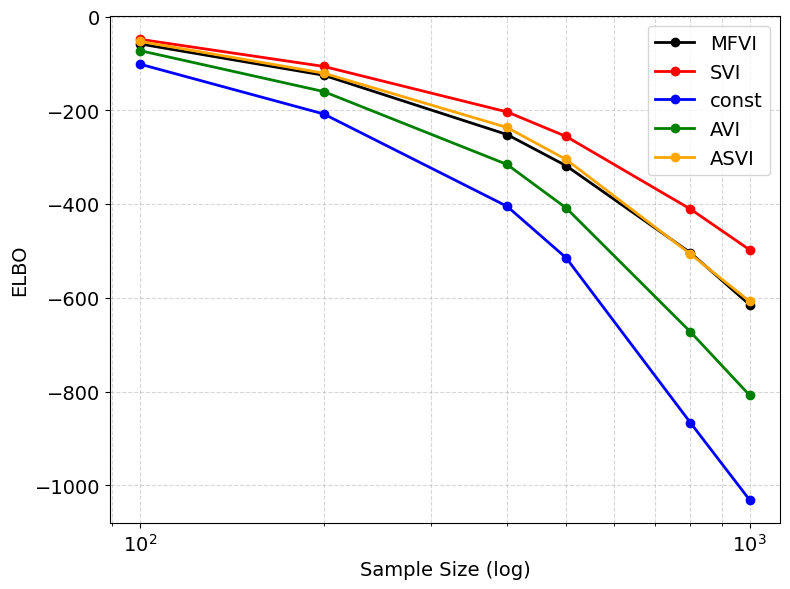

In [20]:
colors = ["black", "red", "blue", "green", "orange"]
plt.figure(figsize=(8, 6))
for j, method in enumerate(method_names):
    plt.plot(sample_sizes,
             combined_loss[:, j],
             marker="o",
             label=method,
             color=colors[j],
             linewidth=2)

# axis labels with larger font
plt.xlabel("Sample Size (log)", fontsize=14)
plt.ylabel("ELBO", fontsize=14)

# tick labels with larger font
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xscale("log")
plt.legend(fontsize=14)
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


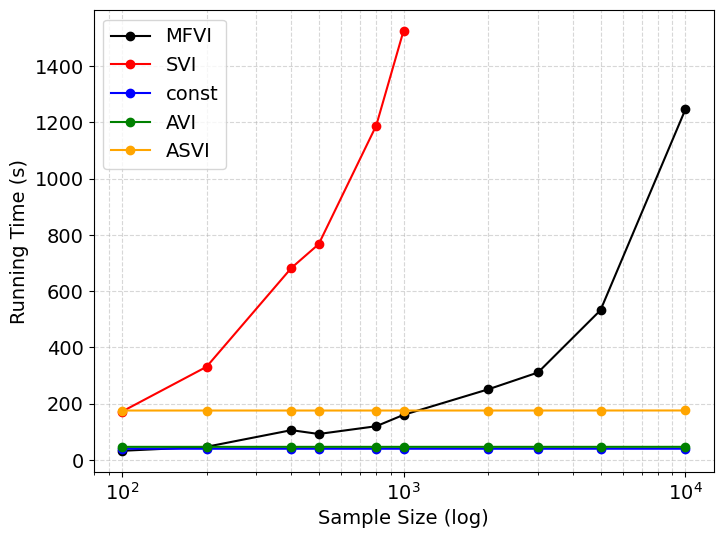

In [27]:
plt.figure(figsize=(8, 6))
for j, method in enumerate(method_names):
    plt.plot(sample_sizes, combined_time[:, j], marker="o", label=method, color=colors[j])

plt.xlabel("Sample Size (log)", fontsize=14)
plt.ylabel("Running Time (s)", fontsize=14)
plt.xscale("log")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which="both", linestyle="--", alpha=0.5)
#plt.title("Running Time vs Sample Size")
#plt.savefig("vi_hmm_nl_time_vs_sample_size.png", dpi=300)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (6,)

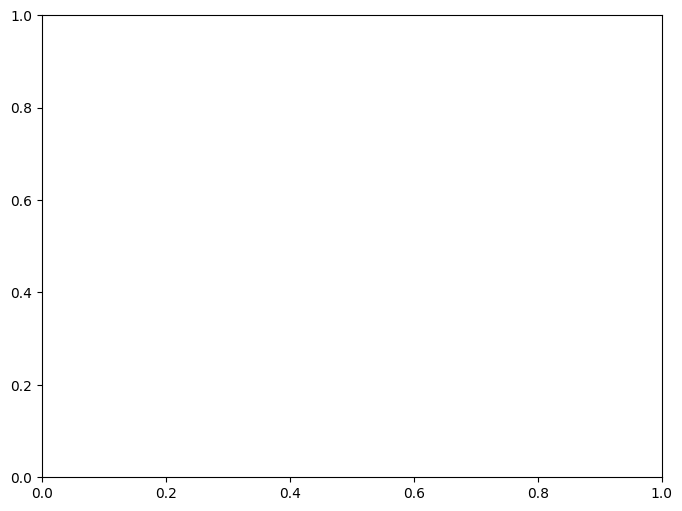

In [179]:
# Plot ELBO vs Sample Size and Running Time
#os.chdir('/home/sfan211/scratch/amortization/plot')
colors = ["black", "red", "blue", "green","orange"]
plt.figure(figsize=(8, 6))
for j, method in enumerate(method_names):
    plt.plot(sample_sizes,
             loss_matrix[:, j],
             marker="o",
             label=method,
             color=colors[j],
             linewidth=2)  # more transparent for alpha≠1 methods

plt.xlabel("Sample Size (N)")
plt.ylabel("-ELBO")
plt.xscale("log")
plt.legend(fontsize=8)
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.title("-ELBO vs Sample Size (Inverted Axis)")
plt.tight_layout()
#plt.savefig("vi_hmm_elbo_vs_sample_size.png", dpi=300)
plt.show()


plt.figure(figsize=(8, 6))
for j, method in enumerate(method_names):
    plt.plot(sample_sizes, time_matrix[:, j], marker="o", label=method, color=colors[j])

plt.xlabel("Sample Size (N)")
plt.ylabel("Running Time (s)")
plt.xscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.title("Running Time vs Sample Size")
plt.savefig("vi_hmm_nl_time_vs_sample_size.png", dpi=300)
plt.show()

# Plot ELBO vs Iteration for each sample size
# Define linestyles
plt.figure(figsize=(14, 9))

for i, N in enumerate(sample_sizes):
    plt.subplot(2, 3, i + 1)
    for j, method in enumerate(method_names):  # method_names = list(methods.keys())
        transparency = 1 if j < 2 else 0.8  # first two methods more solid, others more transparent
        plt.plot(all_elbo_values[N][method],
                 label=method,
                 color=colors[j % len(colors)],
                 linewidth=1.5,
                 alpha=transparency)

    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("-ELBO")
    plt.title(f"N={N}")
    plt.legend(fontsize=8)
    plt.grid(True, which="both", ls="--", lw=0.5)

plt.suptitle("ELBO vs Iterations for Different Sample Sizes", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("vi_hmm_alpha_elbo_vs_iteration.png", dpi=300)
plt.show()